#Importing the Necessary Libraries

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
import lightgbm as lgb
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, PReLU
from tensorflow.keras.optimizers import Nadam
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
sns.set()
%matplotlib inline

#Loading the Datasets

In [ ]:
df = pd.read_csv("/content/salary_train.csv")

In [ ]:
df2 = pd.read_csv("/content/salary_test.csv")

#Checking DataFrame Dimensions

In [ ]:
df.shape

(956, 15)

In [ ]:
df2.shape

(150, 15)

#DataFrame Overview, Statistical Summary, and Missing Value Analysis

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 956 entries, 0 to 955
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         956 non-null    int64  
 1   Job Title          956 non-null    object 
 2   Salary Estimate    956 non-null    object 
 3   Job Description    956 non-null    object 
 4   Rating             956 non-null    float64
 5   Company Name       956 non-null    object 
 6   Location           956 non-null    object 
 7   Headquarters       956 non-null    object 
 8   Size               956 non-null    object 
 9   Founded            956 non-null    int64  
 10  Type of ownership  956 non-null    object 
 11  Industry           956 non-null    object 
 12  Sector             956 non-null    object 
 13  Revenue            956 non-null    object 
 14  Competitors        956 non-null    object 
dtypes: float64(1), int64(2), object(12)
memory usage: 112.2+ KB


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Rating,956.0,3.601255,1.067619,-1.0,3.3,3.8,4.2,5.0
Founded,956.0,1774.605649,598.942517,-1.0,1937.0,1992.0,2008.0,2019.0


In [ ]:
df.isnull().sum()

Unnamed: 0           0
Job Title            0
Salary Estimate      0
Job Description      0
Rating               0
Company Name         0
Location             0
Headquarters         0
Size                 0
Founded              0
Type of ownership    0
Industry             0
Sector               0
Revenue              0
Competitors          0
dtype: int64

In [ ]:
df.drop(['Unnamed: 0'], axis='columns', inplace=True)
df2.drop(['Unnamed: 0'], axis='columns', inplace=True)

In [ ]:
df.head(5)

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue,Competitors
0,Data Scientist,$53K-$91K (Glassdoor est.),"Data Scientist\nLocation: Albuquerque, NM\nEdu...",3.8,Tecolote Research\n3.8,"Albuquerque, NM","Goleta, CA",501 to 1000 employees,1973,Company - Private,Aerospace & Defense,Aerospace & Defense,$50 to $100 million (USD),-1
1,Healthcare Data Scientist,$63K-$112K (Glassdoor est.),What You Will Do:\n\nI. General Summary\n\nThe...,3.4,University of Maryland Medical System\n3.4,"Linthicum, MD","Baltimore, MD",10000+ employees,1984,Other Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),-1
2,Data Scientist,$80K-$90K (Glassdoor est.),"KnowBe4, Inc. is a high growth information sec...",4.8,KnowBe4\n4.8,"Clearwater, FL","Clearwater, FL",501 to 1000 employees,2010,Company - Private,Security Services,Business Services,$100 to $500 million (USD),-1
3,Data Scientist,$56K-$97K (Glassdoor est.),*Organization and Job ID**\nJob ID: 310709\n\n...,3.8,PNNL\n3.8,"Richland, WA","Richland, WA",1001 to 5000 employees,1965,Government,Energy,"Oil, Gas, Energy & Utilities",$500 million to $1 billion (USD),"Oak Ridge National Laboratory, National Renewa..."
4,Data Scientist,$86K-$143K (Glassdoor est.),Data Scientist\nAffinity Solutions / Marketing...,2.9,Affinity Solutions\n2.9,"New York, NY","New York, NY",51 to 200 employees,1998,Company - Private,Advertising & Marketing,Business Services,Unknown / Non-Applicable,"Commerce Signals, Cardlytics, Yodlee"


#Exploratory Data Analysis (EDA) & Data Preprocessing

In [ ]:
df["Rating"].value_counts()

 3.8    75
 3.7    69
 3.9    69
 3.6    56
 4.0    56
 3.5    53
 3.4    47
 4.4    46
 3.3    44
 4.2    41
 4.3    39
 4.7    38
 4.1    37
 3.2    36
-1.0    34
 3.1    30
 5.0    28
 2.9    22
 4.5    19
 4.6    18
 2.7    17
 3.0    17
 4.8    14
 2.6    14
 2.4     8
 2.8     7
 2.1     5
 4.9     4
 2.3     4
 2.2     3
 1.9     3
 2.5     3
Name: Rating, dtype: int64

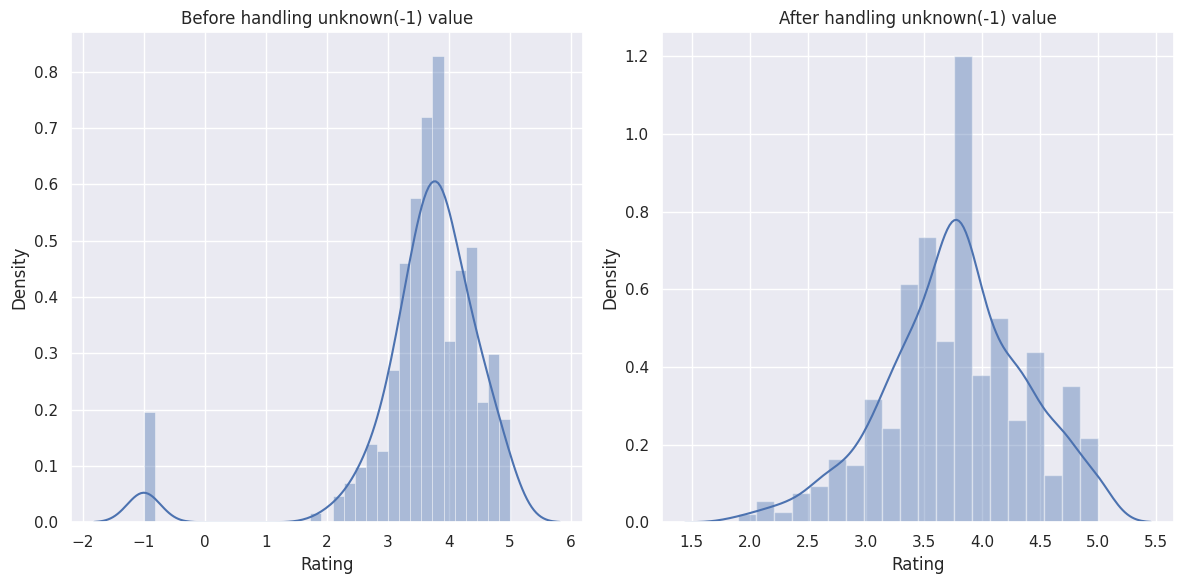

In [ ]:
plt.figure(figsize=(12, 6))

# Plot the histogram before handling the unknown value (-1)
plt.subplot(1, 2, 1)
sns.histplot(
    df["Rating"], kde=True,
    stat="density", kde_kws=dict(cut=3),
    alpha=.4, edgecolor=(1, 1, 1, .4),
)
plt.title('Before handling unknown(-1) value')

# Handle the unknown value (-1) by replacing it with NaN and then filling NaNs with the mean
df['Rating'] = df['Rating'].apply(lambda x: np.NaN if x == -1 else x)
df['Rating'] = df['Rating'].fillna(df['Rating'].mean())

df2['Rating'] = df2['Rating'].apply(lambda x: np.NaN if x == -1 else x)
df2['Rating'] = df2['Rating'].fillna(df2['Rating'].mean())

# Plot the histogram after handling the unknown value (-1)
plt.subplot(1, 2, 2)
sns.histplot(
    df["Rating"], kde=True,
    stat="density", kde_kws=dict(cut=3),
    alpha=.4, edgecolor=(1, 1, 1, .4),
)
plt.title('After handling unknown(-1) value')

plt.tight_layout()
plt.show()

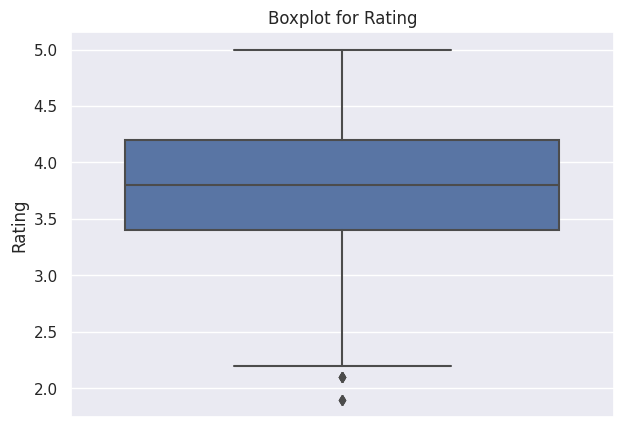

In [ ]:
plt.figure(figsize=(7,5))
sns.boxplot(y='Rating', data=df, orient='v')
plt.title('Boxplot for Rating')
plt.ylabel('Rating')
plt.show()

In [ ]:
df["Founded"].value_counts()

-1       97
 2008    40
 2010    38
 1996    38
 2013    33
         ..
 1945     1
 1860     1
 1942     1
 1878     1
 1889     1
Name: Founded, Length: 109, dtype: int64

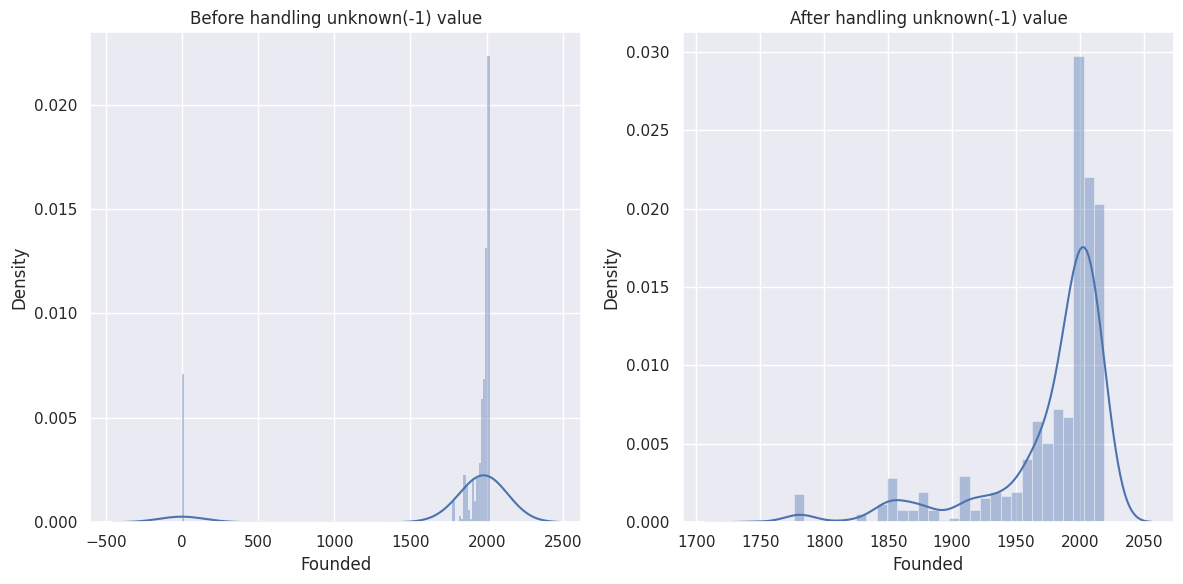

In [ ]:
plt.figure(figsize=(12, 6))

# Plot the histogram before handling the unknown value (-1)
plt.subplot(1, 2, 1)
sns.histplot(
    df["Founded"], kde=True,
    stat="density", kde_kws=dict(cut=3),
    alpha=.4, edgecolor=(1, 1, 1, .4),
)
plt.title('Before handling unknown(-1) value')

# Handle the unknown value (-1) by replacing it with NaN and then filling NaNs with the median
df['Founded'] = df['Founded'].apply(lambda x: np.NaN if x == -1 else x)
df['Founded'] = df['Founded'].fillna(int(df['Founded'].median()))
df['Founded'] = df['Founded'].astype('int')


df2['Founded'] = df2['Founded'].apply(lambda x: np.NaN if x == -1 else x)
df2['Founded'] = df2['Founded'].fillna(int(df2['Founded'].median()))
df2['Founded'] = df2['Founded'].astype('int')

# Plot the histogram after handling the unknown value (-1)
plt.subplot(1, 2, 2)
sns.histplot(
    df["Founded"], kde=True,
    stat="density", kde_kws=dict(cut=3),
    alpha=.4, edgecolor=(1, 1, 1, .4),
)
plt.title('After handling unknown(-1) value')

plt.tight_layout()
plt.show()

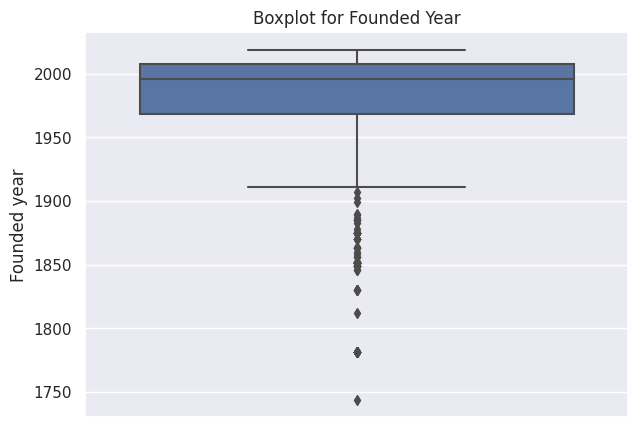

In [ ]:
plt.figure(figsize=(7,5))
sns.boxplot(y='Founded', data=df, orient='v')
plt.title('Boxplot for Founded Year')
plt.ylabel('Founded year')
plt.show()

In [ ]:
df['Job Title'].value_counts().nlargest(40)

Data Scientist                                            178
Data Engineer                                              68
Senior Data Scientist                                      42
Data Analyst                                               18
Senior Data Engineer                                       17
Business Intelligence Analyst                              13
Senior Data Analyst                                        12
Lead Data Scientist                                         8
Data Science Manager                                        7
Principal Data Scientist                                    6
Machine Learning Engineer                                   6
Marketing Data Analyst                                      6
Sr. Data Engineer                                           6
Analytics Manager                                           5
Lead Data Engineer                                          5
Data Engineer 5 - Contract                                  4
Pharmaco

In [ ]:
def group_titles(title):
    title_lower = title.lower()
    if any(keyword in title_lower for keyword in ["data scientist", "scientist"]):
        return "data scientist"
    elif "data engineer" in title_lower:
        return "data engineer"
    elif "machine learning" in title_lower:
        return "ml engineer"
    elif "analyst" in title_lower:
        return "analyst"
    elif "manager" in title_lower:
        return "manager"
    elif 'director' in title_lower:
        return 'director'
    else:
        return "Other"

df['job_title'] = np.vectorize(group_titles)(df['Job Title'])

df2['job_title'] = np.vectorize(group_titles)(df2['Job Title'])

df['job_title'].value_counts()

data scientist    560
data engineer     158
analyst           122
Other              55
manager            35
director           13
ml engineer        13
Name: job_title, dtype: int64

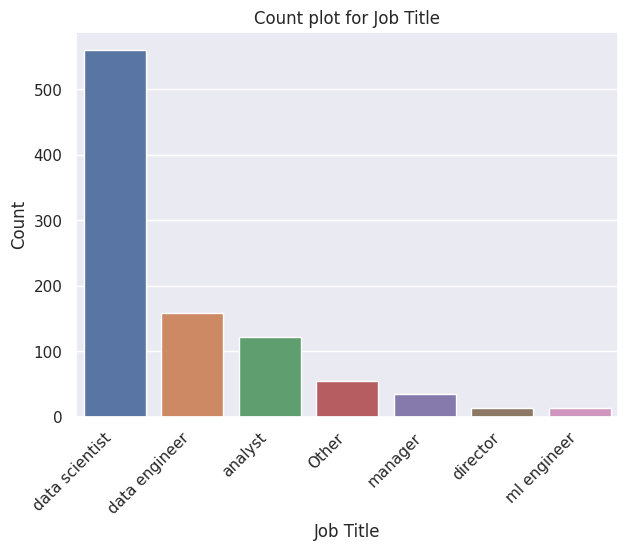

In [ ]:
job_title= df['job_title'].value_counts().index

plt.figure(figsize=(7,5))
sns.countplot(x='job_title', data=df, order = job_title)
plt.title('Count plot for Job Title')
plt.xlabel('Job Title')
plt.ylabel('Count')
plt.xticks(rotation=45, horizontalalignment='right')
plt.show()

In [ ]:
def title_seniority(title):
    seniority_keywords = ['sr.', 'senior', 'lead', 'principal', 'chief']
    junior_keywords = ['junior', 'jr.']

    title_lower = title.lower()

    if any(keyword in title_lower for keyword in seniority_keywords):
        return 'sr'
    elif any(keyword in title_lower for keyword in junior_keywords):
        return 'jr'
    else:
        return 'other'

df['job_seniority'] = [title_seniority(title) for title in df['Job Title']]

df2['job_seniority'] = [title_seniority(title) for title in df2['Job Title']]

df['job_seniority'].value_counts()

other    693
sr       260
jr         3
Name: job_seniority, dtype: int64

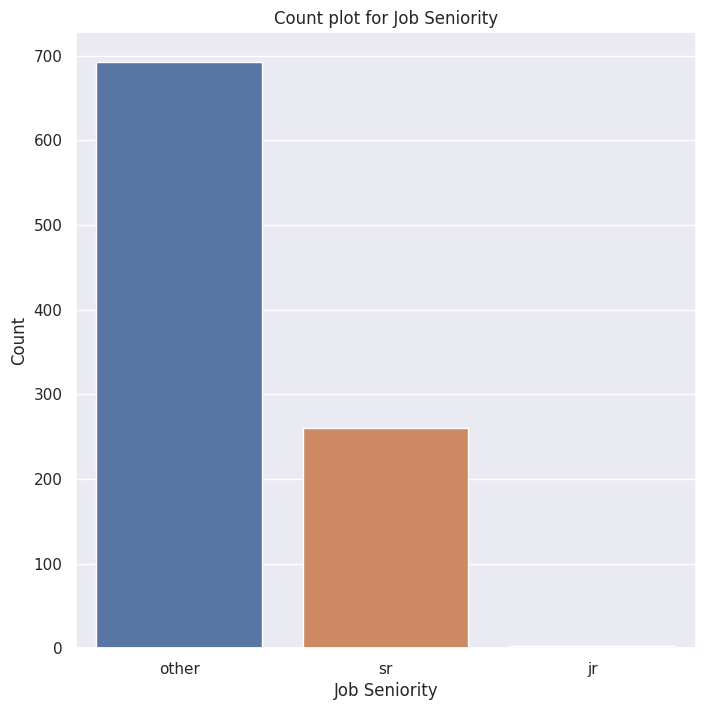

In [ ]:
plt.figure(figsize=(8,8))
sns.countplot(x='job_seniority', data=df, order = df['job_seniority'].value_counts().index)
plt.title('Count plot for Job Seniority')
plt.xlabel('Job Seniority')
plt.ylabel('Count')
plt.show()

In [ ]:
df['Salary'] = df['Salary Estimate'].apply(lambda x: x.split("(")[0])

df2['Salary'] = df2['Salary Estimate'].apply(lambda x: x.split("(")[0])

df['Salary'].value_counts()

-1                  214
$86K-$143K            6
$54K-$115K            6
$49K-$113K            6
$21-$34 Per Hour      6
                   ... 
$74K-$119K            1
$55K-$97K             1
$15K-$16K             1
$61K-$106K            1
$62K-$113K            1
Name: Salary, Length: 417, dtype: int64

In [ ]:
df['Salary'] = df['Salary'].apply(lambda x: np.NaN if x=='-1' else x)
df['Salary'] = df['Salary'].apply(lambda x: x if type(x)== type(3.5) else x.replace('$','').replace('K',''))

df2['Salary'] = df2['Salary'].apply(lambda x: np.NaN if x=='-1' else x)
df2['Salary'] = df2['Salary'].apply(lambda x: x if type(x)== type(3.5) else x.replace('$','').replace('K',''))

df['Salary']

0       53-91 
1      63-112 
2       80-90 
3       56-97 
4      86-143 
        ...   
951    72-133 
952     56-91 
953    95-160 
954        NaN
955    61-126 
Name: Salary, Length: 956, dtype: object

In [ ]:
print("Length of Salary: ",len(df['Salary'].unique()))
df['Salary'].unique()[400:]

Length of Salary:  417


array(['27-47 Per Hour', '68-125 ', '39-67 ', '71-135 ', '61-123 ',
       '87-141 ', '71-121 ', '72-121 ', '51-88 ', '101-141 ', '79-127 ',
       '81-132 ', 'Employer Provided Salary:120-140', '65-113 ',
       '59-125 ', '80-142 ', '62-113 '], dtype=object)

In [ ]:
def process_salary(salary):
    def hourly_to_yearly_range(minlimit, maxlimit):
        min_salary = int(int(minlimit) * 45 * 52 / 1000)
        max_salary = int(int(maxlimit) * 45 * 52 / 1000)
        return f"{min_salary}-{max_salary}"

    def convert_salary(salary):
        if isinstance(salary, float):
            return salary
        salary = salary.lower().replace("employer provided salary:", "")
        if "per hour" in salary:
            min_limit, max_limit = map(int, salary.replace("per hour", "").split('-'))
            return hourly_to_yearly_range(min_limit, max_limit)
        else:
            return salary

    return salary.apply(convert_salary)

df['Salary'] = process_salary(df['Salary'])

df2['Salary'] = process_salary(df2['Salary'])


unique_salaries = df['Salary'].unique()
unique_salaries[400:]

array(['63-109', '68-125 ', '39-67 ', '71-135 ', '61-123 ', '87-141 ',
       '71-121 ', '72-121 ', '51-88 ', '101-141 ', '79-127 ', '81-132 ',
       '120-140', '65-113 ', '59-125 ', '80-142 ', '62-113 '],
      dtype=object)

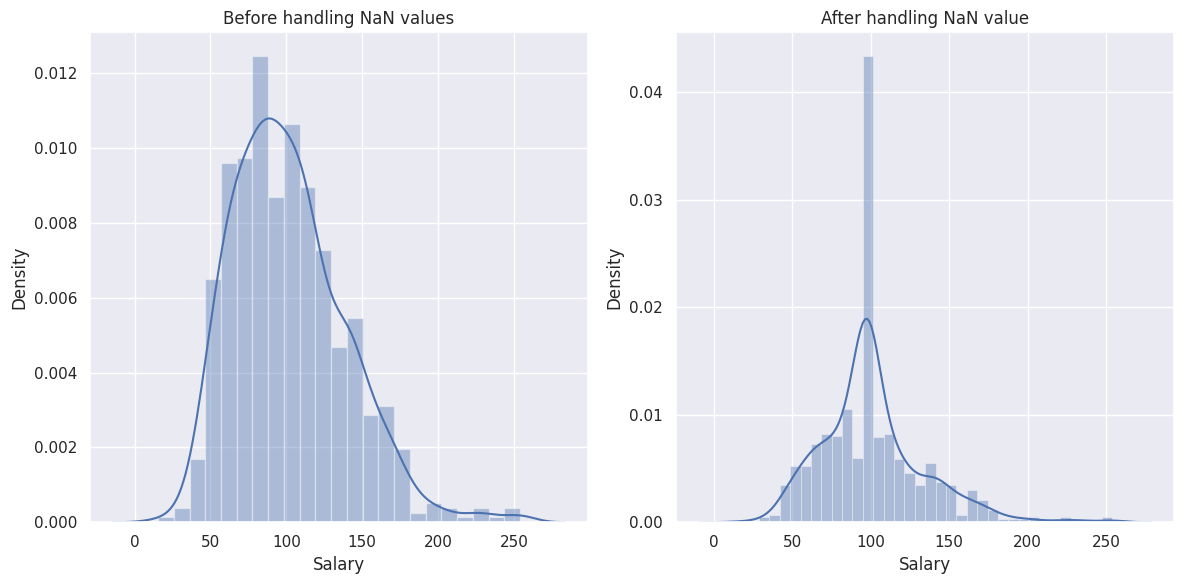

In [ ]:
def transform_salary(salary):
    if isinstance(salary, float):
        return salary
    salary_range = salary.split("-")
    return (int(salary_range[0]) + int(salary_range[1].strip())) / 2

plt.figure(figsize=(12, 6))

df['Salary'] = df['Salary'].apply(transform_salary)

df2['Salary'] = df2['Salary'].apply(transform_salary)

# Plot the histogram before handling NaN values
plt.subplot(1, 2, 1)
sns.histplot(
    df["Salary"], kde=True,
    stat="density", kde_kws=dict(cut=3),
    alpha=.4, edgecolor=(1, 1, 1, .4),
)
plt.title('Before handling NaN values')

# Handle NaN values by filling with median
df['Salary'] = df['Salary'].fillna(df['Salary'].median())

df2['Salary'] = df2['Salary'].fillna(df2['Salary'].median())

# Plot the histogram after handling NaN values
plt.subplot(1, 2, 2)
sns.histplot(
    df["Salary"], kde=True,
    stat="density", kde_kws=dict(cut=3),
    alpha=.4, edgecolor=(1, 1, 1, .4),
)
plt.title('After handling NaN value')

plt.tight_layout()
plt.show()

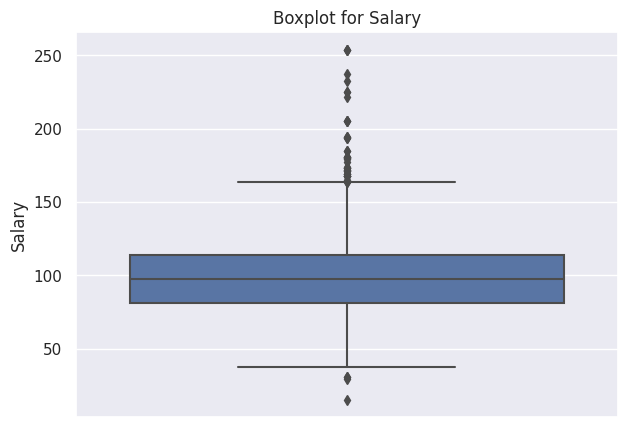

In [ ]:
plt.figure(figsize=(7,5))
g = sns.boxplot(y='Salary', data=df, orient='v')
p = plt.title('Boxplot for Salary')
p = plt.ylabel('Salary')

Total number of unique company name: 448


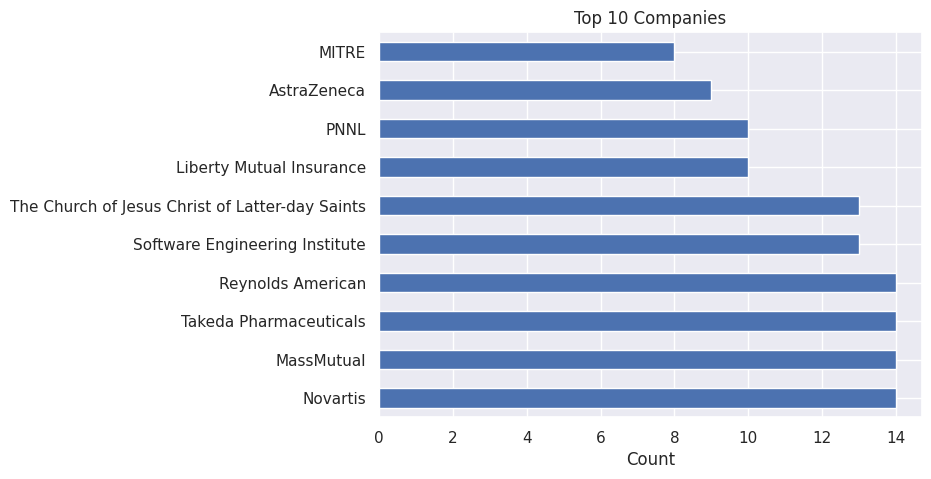

In [ ]:
df["Company Name"] = df["Company Name"].str.split("\n").str[0]

df2["Company Name"] = df2["Company Name"].str.split("\n").str[0]

print('Total number of unique company name:', len(df["Company Name"].unique()))

top_10_companies = df["Company Name"].value_counts().nlargest(10)

plt.figure(figsize=(7, 5))
top_10_companies.plot(kind='barh')
plt.title('Top 10 Companies')
plt.xlabel('Count')
plt.show()

Total number of unique locations: 46


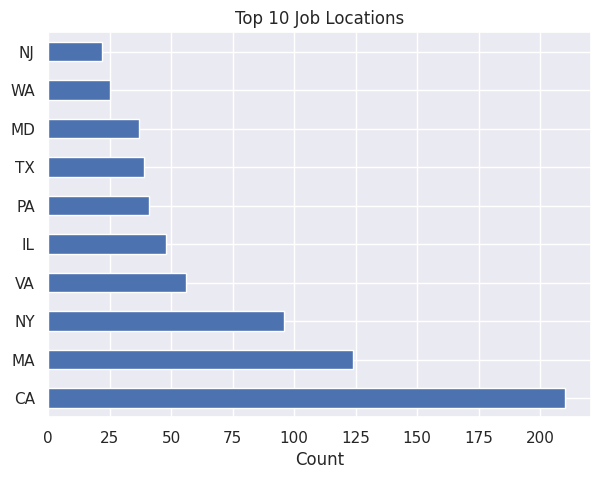

In [ ]:
df['job_location'] = df['Location'].apply(lambda x: x.split(',')[1].strip() if ',' in x else x)

df2['job_location'] = df2['Location'].apply(lambda x: x.split(',')[1].strip() if ',' in x else x)

print('Total number of unique locations:', len(df['job_location'].unique()))

top_10_locations = df['job_location'].value_counts().nlargest(10)

plt.figure(figsize=(7, 5))
top_10_locations.plot(kind='barh')
plt.title('Top 10 Job Locations')
plt.xlabel('Count')
plt.show()

In [ ]:
df['Size'].value_counts()

1001 to 5000 employees     177
201 to 500 employees       160
51 to 200 employees        155
10000+ employees           154
501 to 1000 employees      144
5001 to 10000 employees     79
1 to 50 employees           61
Unknown                     15
-1                          11
Name: Size, dtype: int64

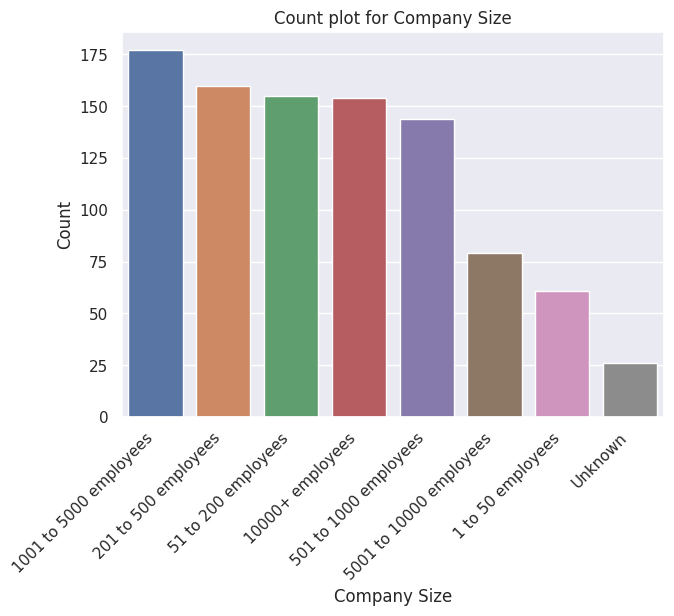

In [ ]:
df['Size'] = df['Size'].str.replace('-1', 'Unknown')

df2['Size'] = df2['Size'].str.replace('-1', 'Unknown')

size= df['Size'].value_counts().index

plt.figure(figsize=(7, 5))
sns.countplot(x='Size', data=df, order=size)
plt.title('Count plot for Company Size')
plt.xlabel('Company Size')
plt.ylabel('Count')
plt.xticks(rotation=45, horizontalalignment='right')
plt.show()

In [ ]:
df['Type of ownership'].value_counts()

Company - Private                 532
Company - Public                  237
Nonprofit Organization             65
Subsidiary or Business Segment     40
Government                         17
Hospital                           15
College / University               15
Unknown                            11
-1                                 11
Other Organization                  5
Contract                            5
School / School District            2
Private Practice / Firm             1
Name: Type of ownership, dtype: int64

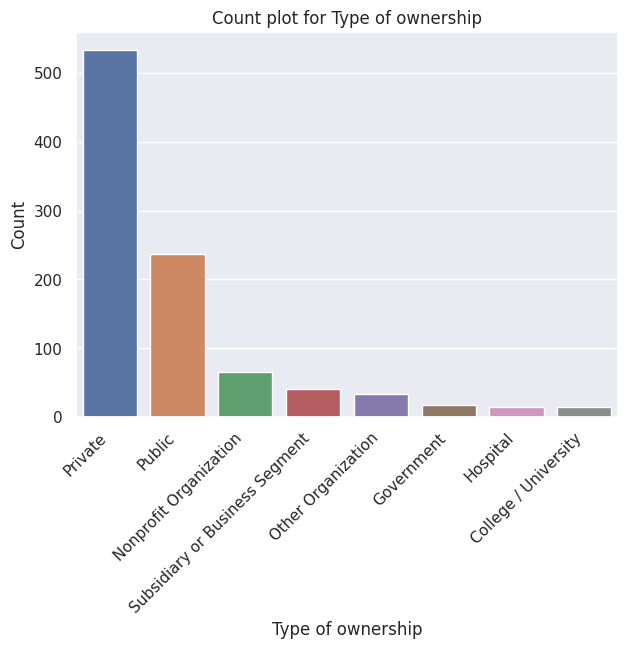

In [ ]:
def clean_ownership(text):
    return 'Private' if 'private' in text.lower() else \
           'Public' if 'public' in text.lower() else \
           'Other Organization' if ('-1' in text.lower() or
                                   'unknown' in text.lower() or
                                   'school / school district' in text.lower() or
                                   'private practice / firm' in text.lower() or
                                   'contract' in text.lower()) else text

df['Type of ownership'] = df['Type of ownership'].apply(clean_ownership)
df2['Type of ownership'] = df2['Type of ownership'].apply(clean_ownership)


plt.figure(figsize=(7, 5))
sns.countplot(x='Type of ownership', data=df, order=df['Type of ownership'].value_counts().index)
plt.title('Count plot for Type of ownership')
plt.xlabel('Type of ownership')
plt.ylabel('Count')
plt.xticks(rotation=45, horizontalalignment='right')
plt.show()

In [ ]:
df['Industry'].value_counts()

Biotech & Pharmaceuticals                   148
IT Services                                  77
Computer Hardware & Software                 70
Insurance Carriers                           65
Enterprise Software & Network Solutions      56
                                           ... 
Farm Support Services                         1
Transportation Equipment Manufacturing        1
Motion Picture Production & Distribution      1
Other Retail Stores                           1
Beauty & Personal Accessories Stores          1
Name: Industry, Length: 63, dtype: int64

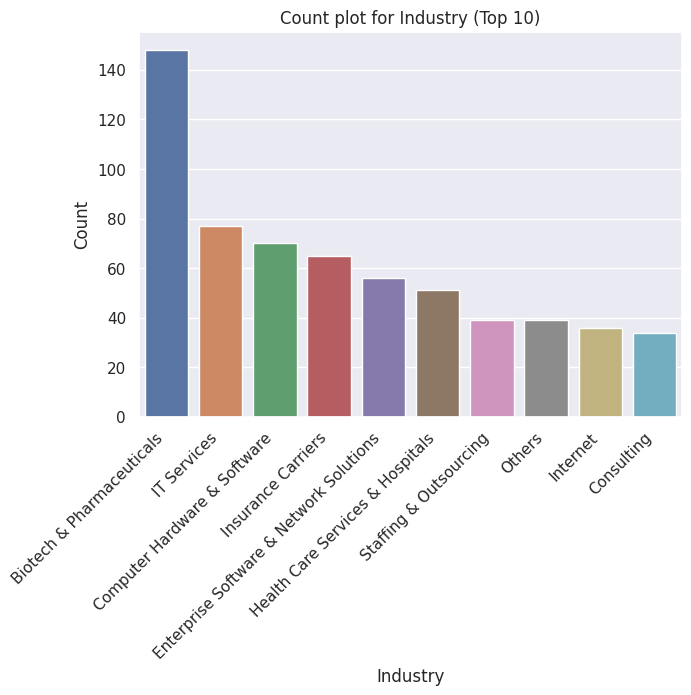

In [ ]:
df['Industry'] = df['Industry'].apply(lambda x: 'Others' if x=='-1' else x)

df2['Industry'] = df2['Industry'].apply(lambda x: 'Others' if x=='-1' else x)

top_10_industry = df['Industry'].value_counts().nlargest(10).index

plt.figure(figsize=(7,5))
sns.countplot(x='Industry', data=df, order = top_10_industry)
plt.title('Count plot for Industry (Top 10)')
plt.xlabel('Industry')
plt.ylabel('Count')
plt.xticks(rotation=45, horizontalalignment='right')
plt.show()

In [ ]:
df['Sector'].value_counts()

Information Technology                239
Biotech & Pharmaceuticals             148
Business Services                     134
Insurance                              71
Finance                                56
Health Care                            51
Manufacturing                          40
-1                                     39
Aerospace & Defense                    32
Education                              26
Retail                                 16
Non-Profit                             16
Oil, Gas, Energy & Utilities           15
Media                                  13
Government                             13
Transportation & Logistics              8
Real Estate                             8
Travel & Tourism                        8
Telecommunications                      6
Arts, Entertainment & Recreation        4
Construction, Repair & Maintenance      4
Consumer Services                       4
Mining & Metals                         3
Agriculture & Forestry            

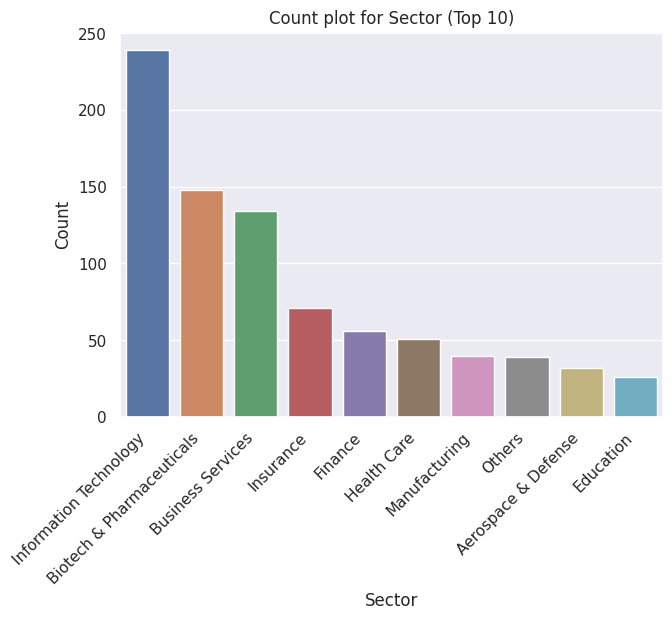

In [ ]:
df['Sector'] = df['Sector'].apply(lambda x: 'Others' if x == '-1' else x)

df2['Sector'] = df2['Sector'].apply(lambda x: 'Others' if x == '-1' else x)

top_10_sector = df['Sector'].value_counts().nlargest(10).index

plt.figure(figsize=(7, 5))
sns.countplot(x='Sector', data=df, order=top_10_sector)
plt.title('Count plot for Sector (Top 10)')
plt.xlabel('Sector')
plt.ylabel('Count')
plt.xticks(rotation=45, horizontalalignment='right')
plt.show()

In [ ]:
df['Revenue'].value_counts()

Unknown / Non-Applicable            299
$10+ billion (USD)                  140
$100 to $500 million (USD)          107
$1 to $2 billion (USD)               68
$500 million to $1 billion (USD)     62
$25 to $50 million (USD)             59
$50 to $100 million (USD)            52
$2 to $5 billion (USD)               44
$10 to $25 million (USD)             39
$5 to $10 million (USD)              29
$5 to $10 billion (USD)              20
$1 to $5 million (USD)               17
-1                                   11
Less than $1 million (USD)            9
Name: Revenue, dtype: int64

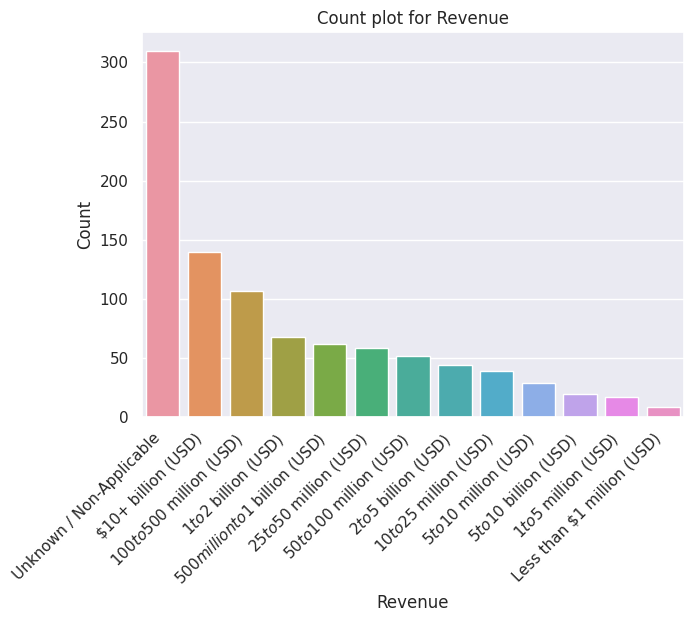

In [ ]:
df['Revenue'] = df['Revenue'].str.replace('-1', 'Unknown / Non-Applicable')

df2['Revenue'] = df2['Revenue'].str.replace('-1', 'Unknown / Non-Applicable')

revenue= df['Revenue'].value_counts().index

plt.figure(figsize=(7, 5))
sns.countplot(x='Revenue', data=df, order=revenue)
plt.title('Count plot for Revenue')
plt.xlabel('Revenue')
plt.ylabel('Count')
plt.xticks(rotation=45, horizontalalignment='right')
plt.show()

In [ ]:
df['Competitors'].value_counts()

-1                                                                                              634
Novartis, Baxter, Pfizer                                                                         14
Oak Ridge National Laboratory, National Renewable Energy Lab, Los Alamos National Laboratory     12
Travelers, Allstate, State Farm                                                                  10
Roche, GlaxoSmithKline, Novartis                                                                  9
                                                                                               ... 
Slalom, Cognizant Technology Solutions, Deloitte                                                  1
Greystar, The Related Companies, Prometheus Real Estate Group                                     1
Ecolab, Eurofin Private Investment Office                                                         1
USAA, Navy Federal Credit Union, Raymond James Financial                                          1


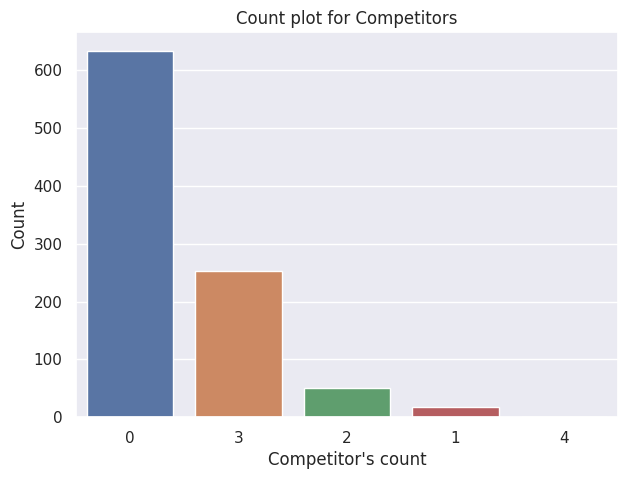

In [ ]:
df['Competitors'] = df['Competitors'].apply(lambda x: len(x.split(',')) if x != '-1' else 0)

df2['Competitors'] = df2['Competitors'].apply(lambda x: len(x.split(',')) if x != '-1' else 0)

competitors = df['Competitors'].value_counts().index

plt.figure(figsize=(7,5))
sns.countplot(x='Competitors', data=df, order = competitors)
plt.title('Count plot for Competitors')
plt.xlabel("Competitor's count")
plt.ylabel('Count')
plt.show()

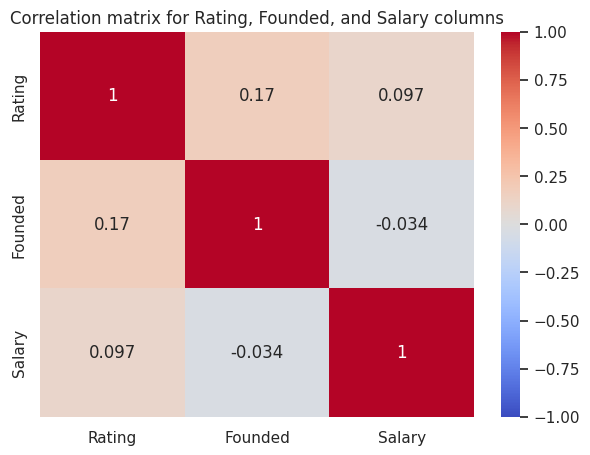

In [ ]:
corr = df[['Rating','Founded','Salary']].corr()

plt.figure(figsize=(7, 5))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation matrix for Rating, Founded, and Salary columns')
plt.show()

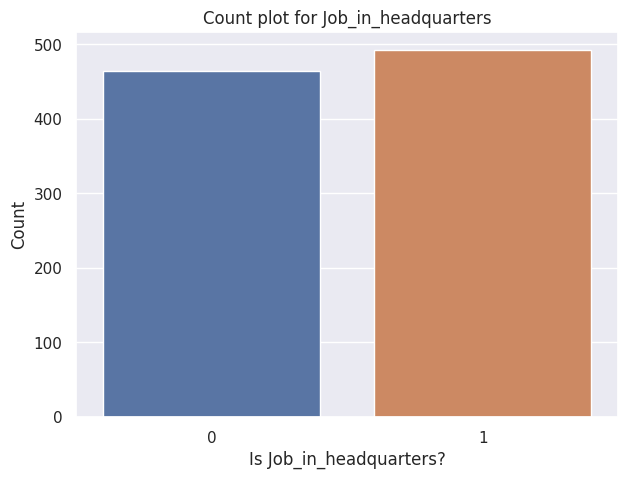

In [ ]:
df['job_in_headquarters'] = df.apply(lambda x: 1 if x['Location'] == x['Headquarters'] else 0, axis=1)

df2['job_in_headquarters'] = df2.apply(lambda x: 1 if x['Location'] == x['Headquarters'] else 0, axis=1)

plt.figure(figsize=(7,5))
sns.countplot(x='job_in_headquarters', data=df)
plt.title('Count plot for Job_in_headquarters')
plt.xlabel("Is Job_in_headquarters?")
plt.ylabel('Count')
plt.show()

In [ ]:
df['python_job'] = df['Job Description'].apply(lambda x: 1 if 'python' in x.lower() else 0)
df['excel_job'] = df['Job Description'].apply(lambda x: 1 if 'excel' in x.lower() else 0)
df['sql_job'] = df['Job Description'].apply(lambda x: 1 if 'sql' in x.lower() else 0)
df['tableau_job'] = df['Job Description'].apply(lambda x: 1 if 'tableau' in x.lower() else 0)

df2['python_job'] = df2['Job Description'].apply(lambda x: 1 if 'python' in x.lower() else 0)
df2['excel_job'] = df2['Job Description'].apply(lambda x: 1 if 'excel' in x.lower() else 0)
df2['sql_job'] = df2['Job Description'].apply(lambda x: 1 if 'sql' in x.lower() else 0)
df2['tableau_job'] = df2['Job Description'].apply(lambda x: 1 if 'tableau' in x.lower() else 0)

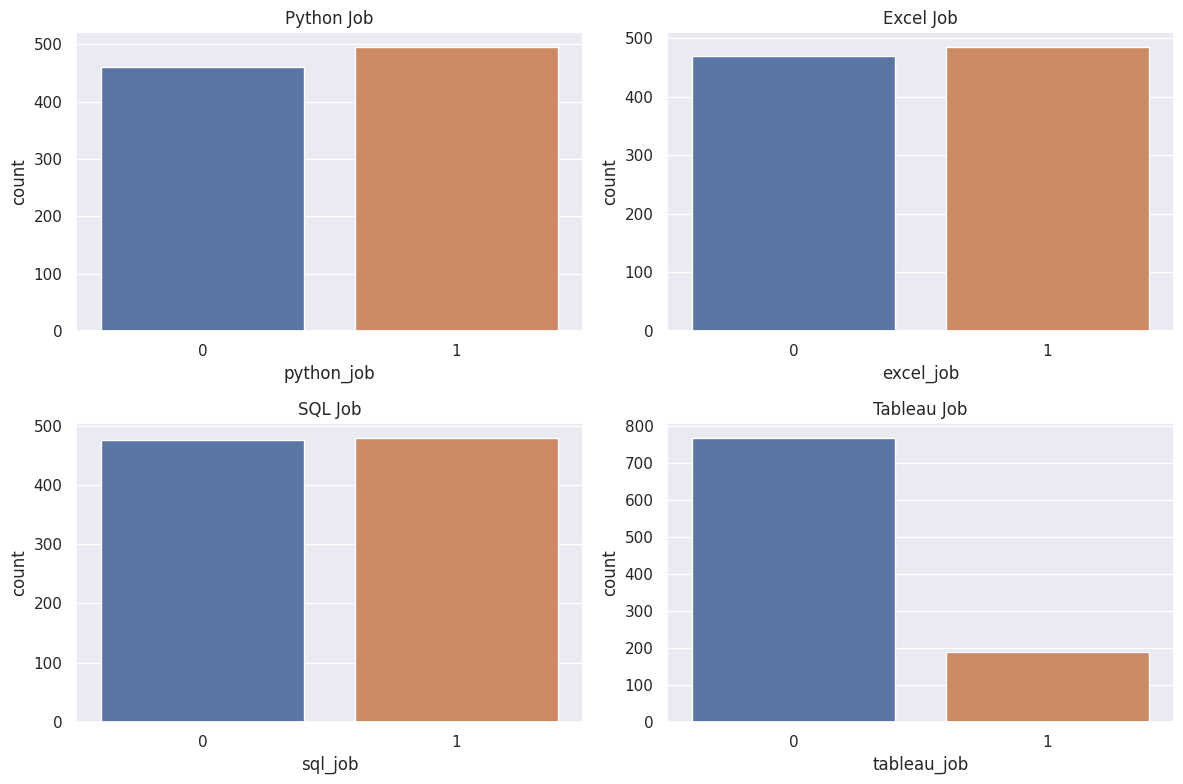

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

sns.countplot(data=df, x='python_job', ax=axes[0, 0])
axes[0, 0].set_title('Python Job')

sns.countplot(data=df, x='excel_job', ax=axes[0, 1])
axes[0, 1].set_title('Excel Job')

sns.countplot(data=df, x='sql_job', ax=axes[1, 0])
axes[1, 0].set_title('SQL Job')

sns.countplot(data=df, x='tableau_job', ax=axes[1, 1])
axes[1, 1].set_title('Tableau Job')

plt.tight_layout()
plt.show()

In [ ]:
sector_list = list(df['Sector'].value_counts()[:10].index)

def sector_simplifier(text):
  if text not in sector_list:
    return 'Others'
  else:
    return text

df['Sector'] = df['Sector'].apply(sector_simplifier)

df2['Sector'] = df2['Sector'].apply(sector_simplifier)

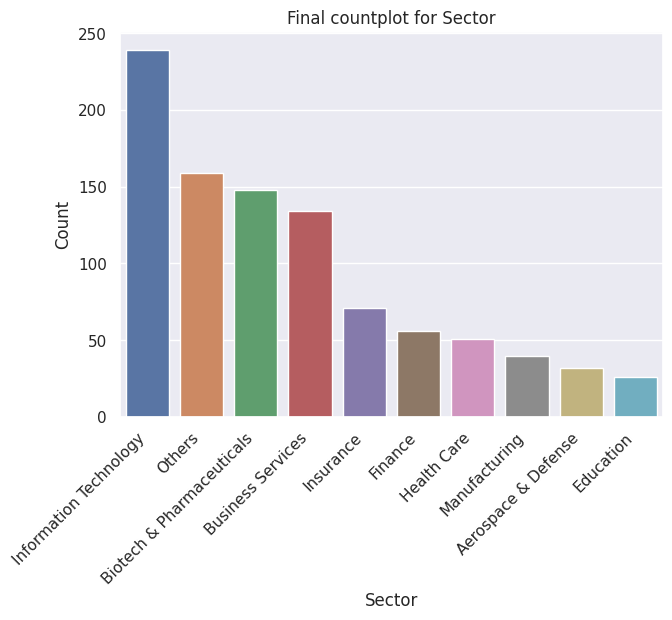

In [ ]:
sector= df['Sector'].value_counts().index

plt.figure(figsize=(7,5))
sns.countplot(x='Sector', data=df, order = sector)
plt.title('Final countplot for Sector')
plt.xlabel('Sector')
plt.ylabel('Count')
plt.xticks(rotation=45, horizontalalignment='right')
plt.show()

In [ ]:
job_location_list = list(df['job_location'].value_counts()[:9].index)

def job_location_simplifier(text):
  if text not in job_location_list:
    return 'Others'
  else:
    return text

df['job_location'] = df['job_location'].apply(job_location_simplifier)


df2['job_location'] = df2['job_location'].apply(job_location_simplifier)

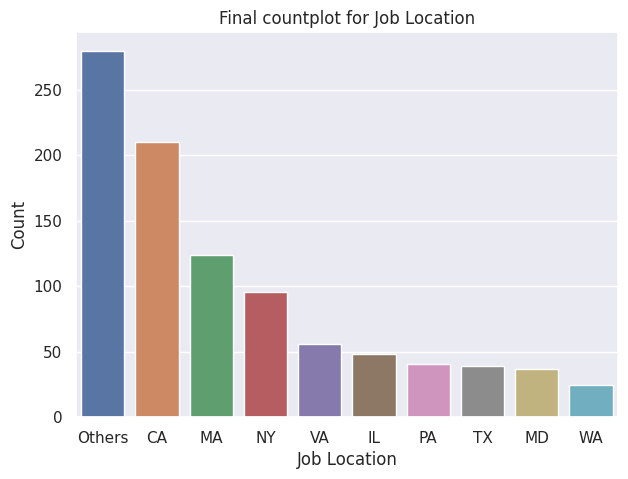

In [ ]:
job_loction= df['job_location'].value_counts().index

plt.figure(figsize=(7,5))
sns.countplot(x= 'job_location', data= df, order= job_loction)
plt.title('Final countplot for Job Location')
plt.xlabel('Job Location')
plt.ylabel('Count')
plt.show()

In [ ]:
df.columns

Index(['Job Title', 'Salary Estimate', 'Job Description', 'Rating',
       'Company Name', 'Location', 'Headquarters', 'Size', 'Founded',
       'Type of ownership', 'Industry', 'Sector', 'Revenue', 'Competitors',
       'job_title', 'job_seniority', 'Salary', 'job_location',
       'job_in_headquarters', 'python_job', 'excel_job', 'sql_job',
       'tableau_job'],
      dtype='object')

In [ ]:
df.drop(['Job Description', 'Location', 'Job Title','Salary Estimate', 'Company Name', 'Headquarters', 'Industry', 'job_location'], axis=1, inplace=True)

df2.drop(['Job Description', 'Location', 'Job Title','Salary Estimate', 'Company Name', 'Headquarters', 'Industry', 'job_location'], axis=1, inplace=True)

In [ ]:
print(df.columns)

print(df2.columns)

Index(['Rating', 'Size', 'Founded', 'Type of ownership', 'Sector', 'Revenue',
       'Competitors', 'job_title', 'job_seniority', 'Salary',
       'job_in_headquarters', 'python_job', 'excel_job', 'sql_job',
       'tableau_job'],
      dtype='object')
Index(['Rating', 'Size', 'Founded', 'Type of ownership', 'Sector', 'Revenue',
       'Competitors', 'job_title', 'job_seniority', 'Salary',
       'job_in_headquarters', 'python_job', 'excel_job', 'sql_job',
       'tableau_job'],
      dtype='object')


In [ ]:
df.rename(columns={'Rating':'company_rating', 'Size':'company_size', 'Founded':'company_founded', 'Type of ownership':'type_of_ownership',
                   'Sector':'sector', 'Revenue':'revenue', 'Competitors':'competitors', 'Salary': 'salary'}, inplace=True)

df2.rename(columns={'Rating':'company_rating', 'Size':'company_size', 'Founded':'company_founded', 'Type of ownership':'type_of_ownership',
                   'Sector':'sector', 'Revenue':'revenue', 'Competitors':'competitors', 'Salary': 'salary'}, inplace=True)

In [ ]:
size_map = {'Unknown': 0, '1 to 50 employees': 1, '51 to 200 employees': 2, '201 to 500 employees': 3,
            '501 to 1000 employees': 4, '1001 to 5000 employees': 5, '5001 to 10000 employees': 6, '10000+ employees': 7}

df['company_size'] = df['company_size'].map(size_map)

df2['company_size'] = df2['company_size'].map(size_map)

In [ ]:
revenue_map = {'Unknown / Non-Applicable': 0, 'Less than $1 million (USD)': 1, '$1 to $5 million (USD)': 2, '$5 to $10 million (USD)': 3,
            '$10 to $25 million (USD)': 4, '$25 to $50 million (USD)': 5, '$50 to $100 million (USD)': 6, '$100 to $500 million (USD)': 7,
            '$500 million to $1 billion (USD)': 8, '$1 to $2 billion (USD)': 9, '$2 to $5 billion (USD)':10, '$5 to $10 billion (USD)':11,
            '$10+ billion (USD)':12}

df['revenue'] = df['revenue'].map(revenue_map)

df2['revenue'] = df2['revenue'].map(revenue_map)

In [ ]:
job_seniority_map = {'other': 0, 'jr': 1, 'sr': 2}

df['job_seniority'] = df['job_seniority'].map(job_seniority_map)

df2['job_seniority'] = df2['job_seniority'].map(job_seniority_map)

In [ ]:
print('Before: {}'.format(df.shape))
df = pd.get_dummies(df, columns=['type_of_ownership'], prefix='ownership')

df2 = pd.get_dummies(df2, columns=['type_of_ownership'], prefix='ownership')

print('After: {}'.format(df.shape))

Before: (956, 15)
After: (956, 22)


In [ ]:
print('Before: {}'.format(df.shape))
df = pd.get_dummies(df, columns=['sector'])

df2 = pd.get_dummies(df2, columns=['sector'])

print('After: {}'.format(df.shape))

Before: (956, 22)
After: (956, 31)


In [ ]:
print('Before: {}'.format(df.shape))
df = pd.get_dummies(df, columns=['job_title'])

df2 = pd.get_dummies(df2, columns=['job_title'])

print('After: {}'.format(df.shape))

Before: (956, 31)
After: (956, 37)


In [ ]:
df.drop(labels=['ownership_Other Organization', 'sector_Others', 'job_title_Other'], axis=1, inplace=True)

##Feature Selection, Scaling, and Data Preparation

In [ ]:
X = df.drop('salary', axis=1)
y = df['salary']

In [ ]:
X2 = df2.drop('salary', axis=1)
y2 = df2['salary']

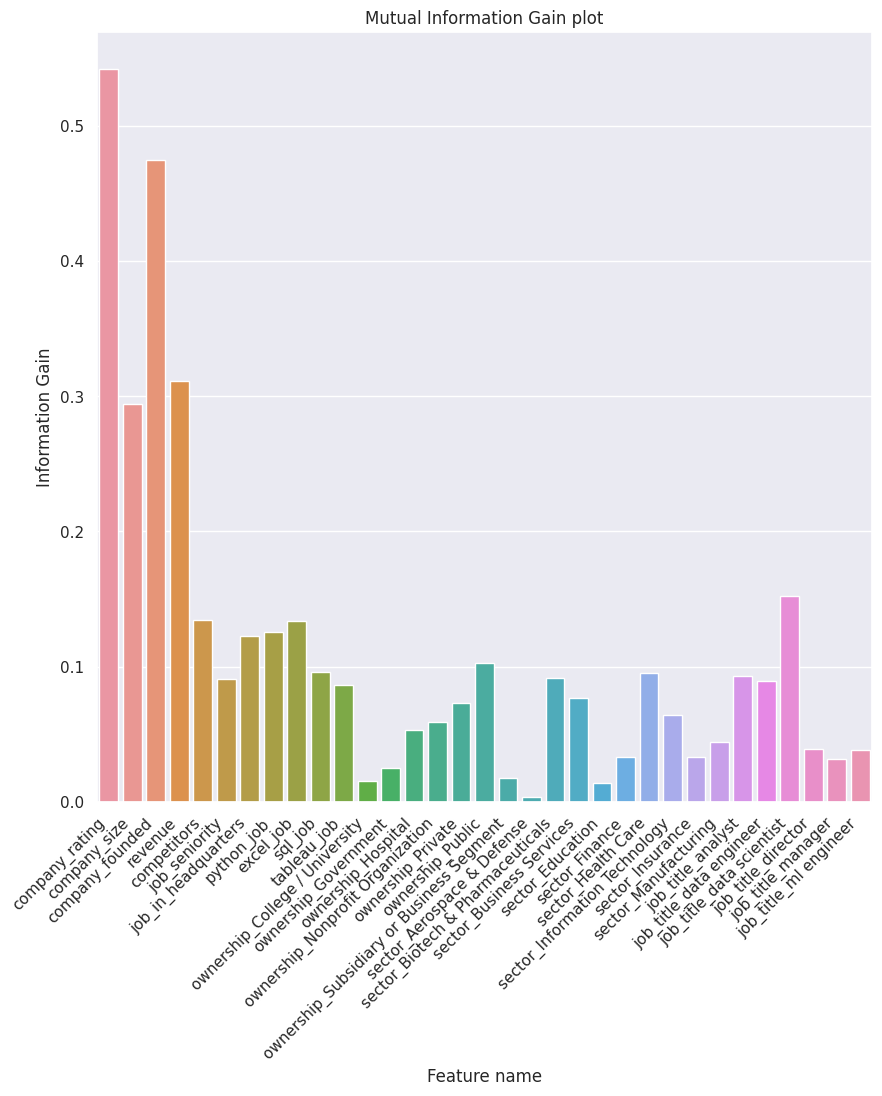

In [ ]:
fs = SelectKBest(score_func=mutual_info_regression, k='all')


fs2= fs.fit(X2, y2)

fs1= fs.fit(X, y)

plt.figure(figsize=(10,10))
sns.barplot(x=X.columns, y=fs1.scores_)
plt.title('Mutual Information Gain plot')
plt.xlabel('Feature name')
plt.ylabel('Information Gain')
plt.xticks(rotation=45, horizontalalignment='right')
plt.show()

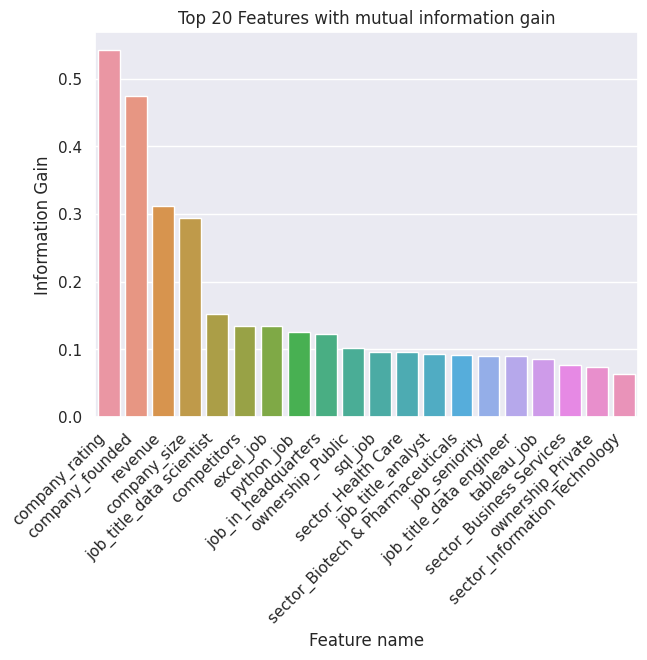

In [ ]:
feature_imp = pd.DataFrame(fs1.scores_, columns=['Score'], index=X.columns)

feature_imp2 = pd.DataFrame(fs2.scores_, columns=['Score'], index=X.columns)

top20_feature = feature_imp.nlargest(n=20, columns=['Score'])

plt.figure(figsize=(7,5))
sns.barplot(x=top20_feature.index, y=top20_feature['Score'])
plt.title('Top 20 Features with mutual information gain')
plt.xlabel('Feature name')
plt.ylabel('Information Gain')
plt.xticks(rotation=45, horizontalalignment='right')
plt.show()

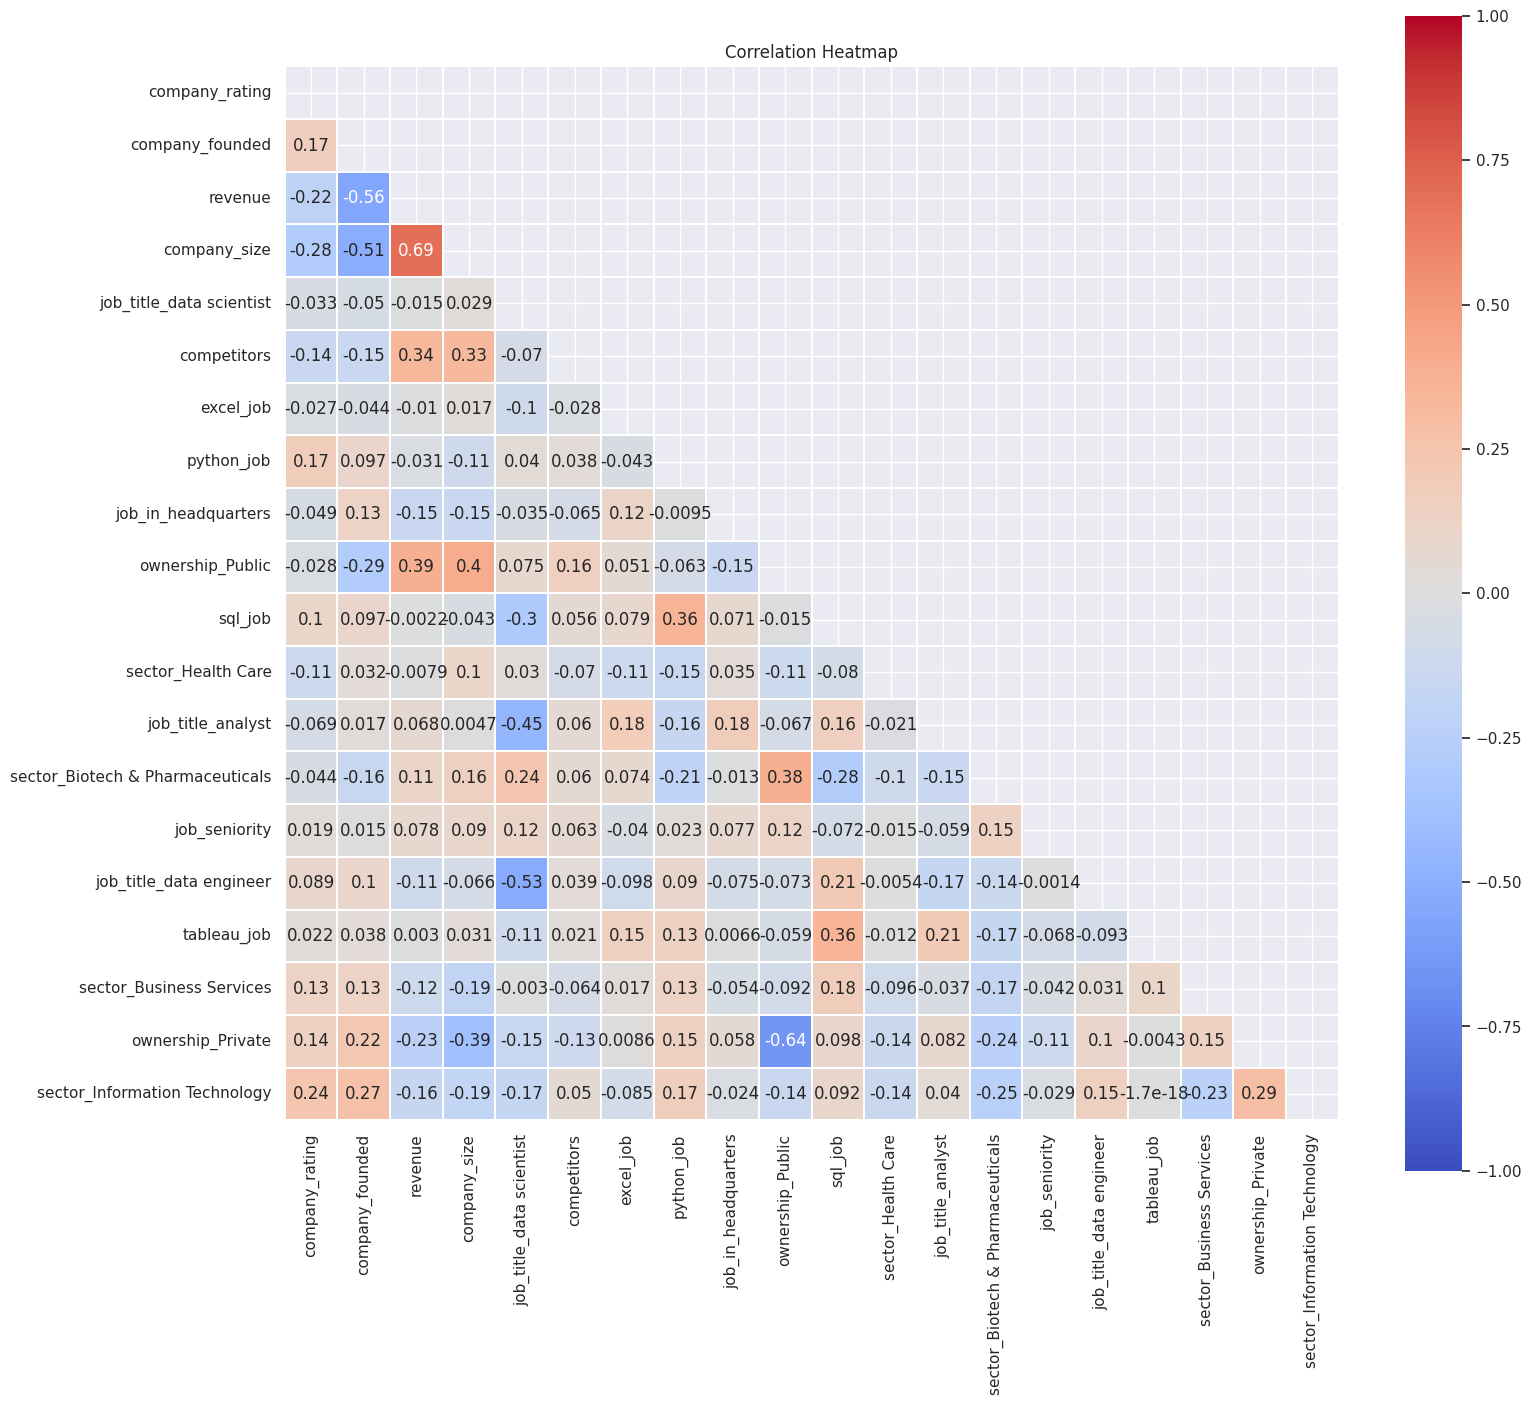

In [ ]:
corr = X[top20_feature.index].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(17, 15))
sns.heatmap(corr, annot=True, mask=mask, cmap='coolwarm', vmin= -1, vmax=1, center=0, square=True, linewidths=0.05)
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
X = X[top20_feature.index]

X2 = X2[top20_feature.index]

print(X.columns)
print(X2.columns)

Index(['company_rating', 'company_founded', 'revenue', 'company_size',
       'job_title_data scientist', 'competitors', 'excel_job', 'python_job',
       'job_in_headquarters', 'ownership_Public', 'sql_job',
       'sector_Health Care', 'job_title_analyst',
       'sector_Biotech & Pharmaceuticals', 'job_seniority',
       'job_title_data engineer', 'tableau_job', 'sector_Business Services',
       'ownership_Private', 'sector_Information Technology'],
      dtype='object')
Index(['company_rating', 'company_founded', 'revenue', 'company_size',
       'job_title_data scientist', 'competitors', 'excel_job', 'python_job',
       'job_in_headquarters', 'ownership_Public', 'sql_job',
       'sector_Health Care', 'job_title_analyst',
       'sector_Biotech & Pharmaceuticals', 'job_seniority',
       'job_title_data engineer', 'tableau_job', 'sector_Business Services',
       'ownership_Private', 'sector_Information Technology'],
      dtype='object')


In [ ]:
sc = StandardScaler()

X_prev=  X.copy()
X2_prev=  X2.copy()

X['company_rating'] = sc.fit_transform(X[['company_rating']])
X['company_founded'] = sc.fit_transform(X[['company_founded']])

X2['company_rating'] = sc.fit_transform(X2[['company_rating']])
X2['company_founded'] = sc.fit_transform(X2[['company_founded']])

#Machine Learning Models

##Hyperparameter Tuning and Evaluation of Linear Regression Model

In [ ]:
lr = LinearRegression()

param_grid = {
    'fit_intercept': [True, False],
}

grid_search = GridSearchCV(lr, param_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X, y)

In [ ]:
best_params = grid_search.best_params_
best_lr = grid_search.best_estimator_

best_lr.fit(X, y)

y_pred = best_lr.predict(X2)

mse = mean_squared_error(y2, y_pred)
nrmse = -np.sqrt(mse)
r2 = r2_score(y2, y_pred)

print('--- Best Linear Regression Model Hyperparameters ---')
print(best_params)
print('Mean Squared Error (MSE): {}'.format(round(mse, 3)))
print('Normalized Root Mean Squared Error (NRMSE): {}'.format(round(nrmse, 3)))
print('R-squared (R2) Score: {}'.format(round(r2, 3)))

--- Best Linear Regression Model Hyperparameters ---
{'fit_intercept': True}
Mean Squared Error (MSE): 683.02
Normalized Root Mean Squared Error (NRMSE): -26.135
R-squared (R2) Score: 0.275


##Hyperparameter Tuning and Evaluation of RandomForestRegressor Model

In [ ]:
rfr = RandomForestRegressor()

param_grid = {
    'n_estimators': [200, 500, 1000],
    'max_depth': [None, 10, 15],
}

grid_search = GridSearchCV(rfr, param_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X, y)

In [ ]:
best_params = grid_search.best_params_
best_rfr = grid_search.best_estimator_

best_rfr.fit(X, y)

y_pred = best_rfr.predict(X2)

mse = mean_squared_error(y2, y_pred)
nrmse = -np.sqrt(mse)
r2 = r2_score(y2, y_pred)

print('--- Best RandomForestRegressor Model Hyperparameters ---')
print(best_params)
print('Mean Squared Error (MSE): {}'.format(round(mse, 3)))
print('Normalized Root Mean Squared Error (NRMSE): {}'.format(round(nrmse, 3)))
print('R-squared (R2) Score: {}'.format(round(r2, 3)))

--- Best RandomForestRegressor Model Hyperparameters ---
{'max_depth': None, 'n_estimators': 200}
Mean Squared Error (MSE): 176.814
Normalized Root Mean Squared Error (NRMSE): -13.297
R-squared (R2) Score: 0.812


##Hyperparameter Tuning and Evaluation of GradientBoostingRegressor Model

In [ ]:
gb = GradientBoostingRegressor()

param_grid = {
    'n_estimators': [200, 500, 1000],
    'learning_rate': [0.2, 0.5, 1],
    'max_depth': [None, 3, 10,15],
}

grid_search = GridSearchCV(gb, param_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X, y)

In [ ]:
best_params = grid_search.best_params_
best_gb = grid_search.best_estimator_

best_gb.fit(X, y)

y_pred = best_gb.predict(X2)

mse = mean_squared_error(y2, y_pred)
nrmse = -np.sqrt(mse)
r2 = r2_score(y2, y_pred)

print('--- Best Gradient Boosting Regressor Model Hyperparameters ---')
print(best_params)
print('Mean Squared Error (MSE): {}'.format(round(mse, 3)))
print('Normalized Root Mean Squared Error (NRMSE): {}'.format(round(nrmse, 3)))
print('R-squared (R2) Score: {}'.format(round(r2, 3)))

--- Best Gradient Boosting Regressor Model Hyperparameters ---
{'learning_rate': 0.5, 'max_depth': 10, 'n_estimators': 1000}
Mean Squared Error (MSE): 232.049
Normalized Root Mean Squared Error (NRMSE): -15.233
R-squared (R2) Score: 0.754


##Hyperparameter Tuning and Evaluation of XGBoost Regressor Model

In [ ]:
xgb_reg = xgb.XGBRegressor()

param_grid = {
    'n_estimators': [200, 500, 1000],
    'learning_rate': [0.2, 0.5, 1],
    'max_depth': [None, 3, 10, 15],
}

grid_search = GridSearchCV(xgb_reg, param_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X, y)

In [ ]:
best_params = grid_search.best_params_
best_xgb_reg = grid_search.best_estimator_

best_xgb_reg.fit(X, y)

y_pred = best_xgb_reg.predict(X2)

mse = mean_squared_error(y2, y_pred)
nrmse = -np.sqrt(mse)
r2 = r2_score(y2, y_pred)

print('--- Best XGBoost Regressor Model Hyperparameters ---')
print(best_params)
print('Mean Squared Error (MSE): {}'.format(round(mse, 3)))
print('Normalized Root Mean Squared Error (NRMSE): {}'.format(round(nrmse, 3)))
print('R-squared (R2) Score: {}'.format(round(r2, 3)))

--- Best XGBoost Regressor Model Hyperparameters ---
{'learning_rate': 0.2, 'max_depth': 15, 'n_estimators': 200}
Mean Squared Error (MSE): 128.434
Normalized Root Mean Squared Error (NRMSE): -11.333
R-squared (R2) Score: 0.864


##Hyperparameter Tuning and Evaluation of LightGBM Regressor Model

In [ ]:
lgbm = lgb.LGBMRegressor()

param_grid = {
    'n_estimators': [200, 500, 1000],
    'learning_rate': [0.1, 0.2, 0.5],
    'max_depth': [None, 4, 5, 15],
}

grid_search = GridSearchCV(lgbm, param_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X, y)

In [ ]:
best_params = grid_search.best_params_
best_lgbm = grid_search.best_estimator_

best_lgbm.fit(X, y)

y_pred = best_lgbm.predict(X2)

mse = mean_squared_error(y2, y_pred)
nrmse = -np.sqrt(mse)
r2 = r2_score(y2, y_pred)

print('--- Best LightGBM Model Hyperparameters ---')
print(best_params)
print('Mean Squared Error (MSE): {}'.format(round(mse, 3)))
print('Normalized Root Mean Squared Error (NRMSE): {}'.format(round(nrmse, 3)))
print('R-squared (R2) Score: {}'.format(round(r2, 3)))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000185 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 171
[LightGBM] [Info] Number of data points in the train set: 956, number of used features: 20
[LightGBM] [Info] Start training from score 100.757322
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000150 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 171
[LightGBM] [Info] Number of data points in the train set: 956, number of used features: 20
[LightGBM] [Info] Start training from score 100.757322
--- Best LightGBM Model 

##Hyperparameter Tuning and Evaluation of K-Nearest Neighbors (KNN) Regression Model

In [ ]:
knn = KNeighborsRegressor()

param_grid = {
    'n_neighbors': [5, 7, 9, 12, 15],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

grid_search = GridSearchCV(knn, param_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X, y)

In [ ]:
best_params = grid_search.best_params_
best_knn = grid_search.best_estimator_

best_knn.fit(X, y)

y_pred = best_knn.predict(X2)

mse = mean_squared_error(y2, y_pred)
nrmse = -np.sqrt(mse)
r2 = r2_score(y2, y_pred)

print('--- Best K-Nearest Neighbors (KNN) Regression Model Hyperparameters ---')
print(best_params)
print('Mean Squared Error (MSE): {}'.format(round(mse, 3)))
print('Normalized Root Mean Squared Error (NRMSE): {}'.format(round(nrmse, 3)))
print('R-squared (R2) Score: {}'.format(round(r2, 3)))

--- Best K-Nearest Neighbors (KNN) Regression Model Hyperparameters ---
{'n_neighbors': 15, 'p': 1, 'weights': 'distance'}
Mean Squared Error (MSE): 137.711
Normalized Root Mean Squared Error (NRMSE): -11.735
R-squared (R2) Score: 0.854


##Ensemble Model Using Voting Regressor

In [ ]:
vr = VotingRegressor([('random_forest', best_rfr), ('gradient_boosting', best_gb), ('lgbm', best_lgbm), ('KNN', best_knn)], weights=[1,1,1,1])
vr.fit(X, y)

y_pred = vr.predict(X2)

mse = mean_squared_error(y2, y_pred)
nrmse = -np.sqrt(mse)
r2 = r2_score(y2, y_pred)

print('Mean Squared Error (MSE): {}'.format(round(mse, 3)))
print('Normalized Root Mean Squared Error (NRMSE): {}'.format(round(nrmse, 3)))
print('R-squared (R2) Score: {}'.format(round(r2, 3)))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000159 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 171
[LightGBM] [Info] Number of data points in the train set: 956, number of used features: 20
[LightGBM] [Info] Start training from score 100.757322
Mean Squared Error (MSE): 123.769
Normalized Root Mean Squared Error (NRMSE): -11.125
R-squared (R2) Score: 0.869


##Salary Prediction

In [ ]:
def predict_salary(rating, founded, competitors, revenue, company_size, sector, ownership, job_title, job_in_headquarters, job_seniority, job_skills):
    prediction_input = list()

    prediction_input.append(sc.transform(np.array(rating).reshape(1, -1)))
    prediction_input.append(sc.transform(np.array(founded).reshape(1, -1)))
    prediction_input.append(competitors)

    revenue_map = {
        'Unknown / Non-Applicable': 0,
        'Less than $1 million (USD)': 1,
        '$1 to $5 million (USD)': 2,
        '$5 to $10 million (USD)': 3,
        '$10 to $25 million (USD)': 4,
        '$25 to $50 million (USD)': 5,
        '$50 to $100 million (USD)': 6,
        '$100 to $500 million (USD)': 7,
        '$500 million to $1 billion (USD)': 8,
        '$1 to $2 billion (USD)': 9,
        '$2 to $5 billion (USD)': 10,
        '$5 to $10 billion (USD)': 11,
        '$10+ billion (USD)': 12
    }
    mapped_revenue = revenue_map.get(revenue, 0)
    prediction_input.append(mapped_revenue)

    size_map = {
        'Unknown': 0,
        '1 to 50 employees': 1,
        '51 to 200 employees': 2,
        '201 to 500 employees': 3,
        '501 to 1000 employees': 4,
        '1001 to 5000 employees': 5,
        '5001 to 10000 employees': 6,
        '10000+ employees': 7
    }
    mapped_company_size = size_map.get(company_size, 0)
    prediction_input.append(mapped_company_size)

    sector_columns = ['sector_Biotech & Pharmaceuticals', 'sector_Health Care', 'sector_Insurance',
                      'sector_Business Services', 'sector_Information Technology']
    temp = list(map(int, np.zeros(shape=(1, len(sector_columns)))[0]))
    for index in range(0, len(sector_columns)):
        if sector_columns[index] == 'sector_' + sector:
            temp[index] = 1
            break
    prediction_input = prediction_input + temp

    if ownership == 'ownership_Private':
        prediction_input.append(1)
    else:
        prediction_input.append(0)

    job_title_columns = ['job_title_data scientist', 'job_title_data analyst', 'job_title_data engineer']
    temp = list(map(int, np.zeros(shape=(1, len(job_title_columns)))[0]))
    for index in range(0, len(job_title_columns)):
        if job_title_columns[index] == 'job_title_' + job_title:
            temp[index] = 1
            break
    prediction_input = prediction_input + temp

    prediction_input.append(job_in_headquarters)

    job_seniority_map = {'other': 0, 'jr': 1, 'sr': 2}
    prediction_input.append(job_seniority_map[job_seniority])

    temp = list(map(int, np.zeros(shape=(1, 4))[0]))
    if 'excel_job' in job_skills:
        temp[0] = 1
    if 'python_job' in job_skills:
        temp[1] = 1
    if 'tableau_job' in job_skills:
        temp[2] = 1
    if 'sql_job' in job_skills:
        temp[3] = 1
    prediction_input = prediction_input + temp

    return vr.predict([prediction_input])[0]


In [ ]:
rating_widget = widgets.FloatSlider(min=0, max=5.0, step=0.1, description='Rating:', layout=widgets.Layout(margin='0 0 10px 0'))
founded_widget = widgets.IntText(description='Founded:', layout=widgets.Layout(margin='0 0 10px 0'))
competitors_widget = widgets.IntText(description='Competitors:', layout=widgets.Layout(margin='0 0 10px 0'))
revenue_widget =  widgets.Dropdown(options=['Unknown / Non-Applicable', 'Less than $1 million (USD)', '$1 to $5 million (USD)', '$5 to $10 million (USD)', '$10 to $25 million (USD)', '$25 to $50 million (USD)', '$50 to $100 million (USD)', '$100 to $500 million (USD)', '$500 million to $1 billion (USD)', '$1 to $2 billion (USD)', '$2 to $5 billion (USD)', '$5 to $10 billion (USD)', '$10+ billion (USD)'], description='Revenue:', layout=widgets.Layout(margin='0 0 10px 0'))
company_size_widget = widgets.Dropdown(options=['Unknown', '1 to 50 employees', '51 to 200 employees', '201 to 500 employees', '501 to 1000 employees', '1001 to 5000 employees', '5001 to 10000 employees', '10000+ employees'], description='Company Size:', layout=widgets.Layout(margin='0 0 10px 0'), style={'description_width': 'initial'})
sector_widget = widgets.Dropdown(options=['Biotech & Pharmaceuticals', 'Health Care', 'Insurance', 'Business Services', 'Information Technology'], description='Sector:', layout=widgets.Layout(margin='0 0 10px 0'))
ownership_widget = widgets.Dropdown(options=['Private', 'Public', 'Other'], description='Ownership:', layout=widgets.Layout(margin='0 0 10px 0'))
job_title_widget = widgets.Dropdown(options=['data scientist', 'data analyst', 'data engineer'], description='Job Title:', layout=widgets.Layout(margin='0 0 10px 0'))
job_in_headquarters_widget = widgets.Dropdown(options=[0,1], description='Job in Headquarters:', layout=widgets.Layout(margin='0 0 10px 0'), style={'description_width': 'initial'})
job_seniority_widget = widgets.Dropdown(options=['other', 'jr', 'sr'], description='Job Seniority:', layout=widgets.Layout(margin='0 0 10px 0'))
job_skills_widget = widgets.SelectMultiple(options=['excel', 'python', 'tableau', 'sql'], description='Job Skills:', layout=widgets.Layout(margin='0 0 10px 0'))
predict_button = widgets.Button(description='Predict Salary', layout=widgets.Layout(margin='20px 0 10px 0'))
output = widgets.Output()

def predict_salary_button_click(b):
    with output:
        output.clear_output()
        rating = rating_widget.value
        founded = founded_widget.value
        competitors = competitors_widget.value
        revenue = revenue_widget.value
        company_size = company_size_widget.value
        sector = sector_widget.value
        ownership = ownership_widget.value
        job_title = job_title_widget.value
        job_in_headquarters = job_in_headquarters_widget.value
        job_seniority = job_seniority_widget.value
        job_skills = job_skills_widget.value
        salary = predict_salary(
            rating, founded, competitors, revenue, company_size, sector, ownership,
            job_title, job_in_headquarters, job_seniority, job_skills
        )
        print('Estimated salary (range): {}(USD) to {}(USD) per annum.'.format(int(salary * 1000) - 9000, int(salary * 1000) + 9000))

predict_button.on_click(predict_salary_button_click)

input_widgets = [rating_widget, founded_widget, competitors_widget, revenue_widget,
                 company_size_widget, sector_widget, ownership_widget, job_title_widget,
                 job_in_headquarters_widget, job_seniority_widget, job_skills_widget, predict_button]
for widget in input_widgets:
    display(widget)

display(output)

FloatSlider(value=0.0, description='Rating:', layout=Layout(margin='0 0 10px 0'), max=5.0)

IntText(value=0, description='Founded:', layout=Layout(margin='0 0 10px 0'))

IntText(value=0, description='Competitors:', layout=Layout(margin='0 0 10px 0'))

Dropdown(description='Revenue:', layout=Layout(margin='0 0 10px 0'), options=('Unknown / Non-Applicable', 'Les…

Dropdown(description='Company Size:', layout=Layout(margin='0 0 10px 0'), options=('Unknown', '1 to 50 employe…

Dropdown(description='Sector:', layout=Layout(margin='0 0 10px 0'), options=('Biotech & Pharmaceuticals', 'Hea…

Dropdown(description='Ownership:', layout=Layout(margin='0 0 10px 0'), options=('Private', 'Public', 'Other'),…

Dropdown(description='Job Title:', layout=Layout(margin='0 0 10px 0'), options=('data scientist', 'data analys…

Dropdown(description='Job in Headquarters:', layout=Layout(margin='0 0 10px 0'), options=(0, 1), style=Descrip…

Dropdown(description='Job Seniority:', layout=Layout(margin='0 0 10px 0'), options=('other', 'jr', 'sr'), valu…

SelectMultiple(description='Job Skills:', layout=Layout(margin='0 0 10px 0'), options=('excel', 'python', 'tab…

Button(description='Predict Salary', layout=Layout(margin='20px 0 10px 0'), style=ButtonStyle())

Output()

#Deep Learning Model

##Deep Neural Network (DNN) Training and Evaluation

In [ ]:
model = Sequential()
model.add(Dense(128, input_dim=X.shape[1]))
model.add(PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None))
model.add(Dropout(0.2))
model.add(Dense(256))
model.add(PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None))
model.add(Dropout(0.2))
model.add(Dense(512))
model.add(PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))

optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001)
model.compile(loss='mean_squared_error', optimizer=optimizer)

history = model.fit(X, y, epochs=2000, batch_size=8, verbose=0,)

y_pred = model.predict(X2)

mse = mean_squared_error(y2, y_pred)
nrmse = -np.sqrt(mse)
r2 = r2_score(y2, y_pred)

print('Mean Squared Error (MSE): {}'.format(round(mse, 3)))
print('Normalized Root Mean Squared Error (NRMSE): {}'.format(round(nrmse, 3)))
print('R-squared (R2) Score: {}'.format(round(r2, 3)))

5/5 [==============================] - 0s 5ms/step
Mean Squared Error (MSE): 29.921
Normalized Root Mean Squared Error (NRMSE): -5.47
R-squared (R2) Score: 0.968
